<a href="https://colab.research.google.com/github/DimosthenisDimoulias/datastories_for_emme/blob/main/stance-justification-thematic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving deliberation_comments_104.xlsx to deliberation_comments_104 (16).xlsx


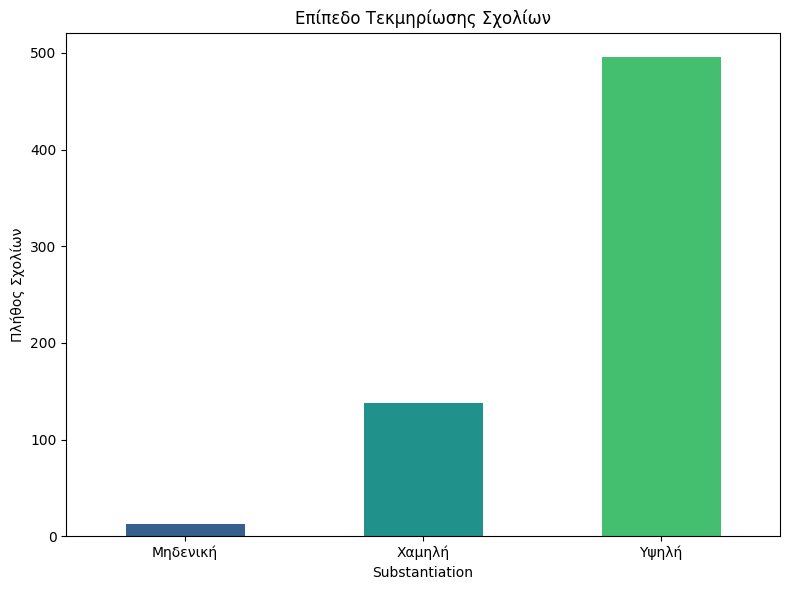

Stance Counts:
Stance
Ουδέτερη/Τεχνική    327
Αρνητική            259
Θετική               61
Name: count, dtype: int64

Substantiation Counts:
Substantiation
Μηδενική     13
Χαμηλή      138
Υψηλή       496
Name: count, dtype: int64

Theme Counts:
Οικονομία/Ανάπτυξη      136
Κοινωνική Δικαιοσύνη    202
Ακαδημαϊκά Κριτήρια     250
Συνταγματικότητα        400
dtype: int64

Sample High Substantiation Comments:
['Στην παράγραφο 5 του άρθρου 16 του Συντάγματος ρυθμίζεται ότι: "H ανώτατη εκπαίδευση παρέχεται αποκλειστικά από ιδρύματα που αποτελούν νομικά πρόσωπα δημοσίου δικαίου με πλήρη αυτοδιοίκηση. Τα ιδρύματα αυτά τελούν υπό την εποπτεία του Κράτους, έχουν δικαίωμα να ενισχύονται οικονομικά από αυτό και λειτουργούν σύμφωνα με τους νόμους που αφορούν τους οργανισμούς τους. Συγχώνευση ή κατάτμηση ανώτατων εκπαιδευτικών ιδρυμάτων μπορεί να γίνει και κατά παρέκκλιση από κάθε αντίθετη διάταξη, όπως νόμος ορίζει. Ειδικός νόμος ορίζει όσα αφορούν τους φοιτητικούς συλλόγους και τη συμμετοχή των 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
from google.colab import files

# Load the dataframe
uploaded = files.upload()

df = pd.read_excel(list(uploaded.keys())[0])

# Preprocessing
df['Σχόλιο'] = df['Σχόλιο'].astype(str)
df['Σχόλιο_lower'] = df['Σχόλιο'].str.lower()

# --- 1. Stance Analysis (Sentiment/Stance) ---
# Keywords
positive_keywords = ['συμφωνώ', 'θετικό', 'ορθό', 'μπράβο', 'επιτέλους', 'αναγκαίο', 'εκσυγχρονισμός', 'ευκαιρία', 'πρόοδος', 'σωστή κατεύθυνση']
negative_keywords = ['διαφωνώ', 'όχι', 'απαράδεκτο', 'απόσυρση', 'αντισυνταγματικό', 'καταστροφή', 'ντροπή', 'αίσχος', 'ιδιωτικοποίηση', 'παραβίαση', 'κατάργηση', 'εμπορευματοποίηση', 'όχι στα ιδιωτικά']

def classify_stance(text):
    text = text.lower()
    # Check for negative first as they are likely more emphatic in this context
    if any(k in text for k in negative_keywords):
        return 'Αρνητική'
    elif any(k in text for k in positive_keywords):
        return 'Θετική'
    else:
        # Heuristic: If it contains specific questions or technical terms without emotive words, maybe Neutral/Technical
        # For simplicity, if not explicitly positive or negative, we map to "Ουδέτερη/Τεχνική"
        # However, many "Withdraw it" comments might be short.
        return 'Ουδέτερη/Τεχνική'

df['Stance'] = df['Σχόλιο'].apply(classify_stance)

# --- 2. Level of Substantiation ---
# Heuristics based on length and vocabulary
def classify_substantiation(text):
    words = text.split()
    num_words = len(words)
    text_lower = text.lower()

    high_keywords = ['άρθρο 16', 'σύνταγμα', 'στε', 'νομολογία', 'ευρωπαϊκό δίκαιο', 'παρ.', 'ν.', 'συνεπώς', 'δεδομένου', 'τεκμηριώνει', 'αντίθεση', 'αιτιολογική έκθεση','εβε','μελέτη','συμβούλιο της επικρατείας','έρευνα','οδηγία','βάση εισαγωγής','ενωσιακό δίκαιο','συνταγμ','επιστημ']

    if num_words < 15:
        return 'Μηδενική'

    # If it has significant length AND technical/legal vocabulary -> High
    if num_words > 50 and any(k in text_lower for k in high_keywords):
        return 'Υψηλή'
    # Or just very long texts often imply effort/argumentation
    if num_words > 150:
        return 'Υψηλή'

    return 'Χαμηλή'

df['Substantiation'] = df['Σχόλιο'].apply(classify_substantiation)

# --- 3. Thematic Framing ---
# Note: A comment can belong to multiple themes
themes = {
    'Συνταγματικότητα': ['σύνταγμα', 'άρθρο 16', 'αντισυνταγματικό', 'νομιμότητα', 'παραβίαση', 'στε'],
    'Ακαδημαϊκά Κριτήρια': ['εβε', 'βάση εισαγωγής', 'ποιότητα', 'αξιολόγηση', 'υποδομές', 'πτυχίο', 'εθχααε', 'εθααε', 'πιστοποίηση', 'επαγγελματικά δικαιώματα', 'αναγνώριση'],
    'Κοινωνική Δικαιοσύνη': ['δίδακτρα', 'πλούσιοι', 'φτωχοί', 'ισότητα', 'ευκαιρίες', 'δωρεάν', 'ταξικό', 'ανισότητες', 'παιδιά'],
    'Οικονομία/Ανάπτυξη': ['brain drain', 'φυγή', 'εξωτερικό', 'κύπρος', 'συνάλλαγμα', 'οικονομία', 'αγορά εργασίας', 'ανταγωνισμός', 'επενδύσεις']
}

theme_counts = {k: 0 for k in themes}

def check_themes(text):
    found_themes = []
    text = text.lower()
    for theme, keywords in themes.items():
        if any(k in text for k in keywords):
            found_themes.append(theme)
    return found_themes

df['Themes'] = df['Σχόλιο'].apply(check_themes)

# Count themes
for theme_list in df['Themes']:
    for theme in theme_list:
        theme_counts[theme] += 1

# --- VISUALIZATIONS ---



# 2. Substantiation Plot
plt.figure(figsize=(8, 6))
subst_counts = df['Substantiation'].value_counts().reindex(['Μηδενική', 'Χαμηλή', 'Υψηλή'])
colors = plt.get_cmap('viridis')([0.3, 0.5, 0.7])
subst_counts.plot(kind='bar', color=colors)
plt.title('Επίπεδο Τεκμηρίωσης Σχολίων')
plt.ylabel('Πλήθος Σχολίων')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('substantiation_analysis.png')
plt.show()


print("Stance Counts:")
print(stance_counts)
print("\nSubstantiation Counts:")
print(subst_counts)
print("\nTheme Counts:")
print(themes_series)
print("\nSample High Substantiation Comments:")
print(df[df['Substantiation']=='Υψηλή']['Σχόλιο'].head(2).tolist())
print("\nSample Negative Comments:")
print(df[df['Stance']=='Αρνητική']['Σχόλιο'].head(2).tolist())